In [49]:
# Loading dependencies.
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from scipy.stats import linregress
import requests
import time
from api_key import ip_api_key
from api_key import ip_api_key2
from api_key import ip_api_key3
from api_key import ip_api_key4
from api_key import ip_api_key5
from datetime import datetime
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
import hvplot.pandas
from holoviews.util.transform import lon_lat_to_easting_northing




In [5]:
# Path to csv.
card_fraud_path_load = Path("resource/merged_file.csv")
card_data = pd.read_csv(card_fraud_path_load)

card_fraud_ernie_path_load = Path("resource/credit_card_fraud_flg_ernie.csv")
card_data_ernie = pd.read_csv(card_fraud_ernie_path_load)

card_fraud_thet_path_load = Path("resource/credit_card_fraud_flg_thet.csv")
card_data_thet = pd.read_csv(card_fraud_thet_path_load)

card_fraud_jimmy_path_load = Path("resource/credit_card_fraud_flg_jimmy.csv")
card_data_jimmy = pd.read_csv(card_fraud_jimmy_path_load)

card_fraud_mounika_path_load = Path("resource/credit_card_fraud_flg_mounika.csv")
card_data_mounika = pd.read_csv(card_fraud_mounika_path_load)

card_data.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Card Expiration Date,CVV Code (Hashed or Encrypted),Transaction Response Code,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes
0,db096aac-6835-495e-aaa3-4d82665d156a,147.17.133.152,Waltham,42.40632,-71.27939,North America,"Washington, D.C.",United States,2023-04-15 20:28:31,2500.93,...,10/28,9f6cb78c09b22a1a10564f6be4a1784327a42ff11a10a3...,5,1,1,In-Person,147.17.133.152,Desktop,NaN,Natus voluptates officiis quod delectus corrup...
1,5aca5952-cc27-4d6f-b612-d7af473b73e1,17.97.43.210,Cupertino,37.32268,-122.03005,North America,"Washington, D.C.",United States,2020-04-28 08:36:05,3369.30,...,11/25,8eba3ded9f5f3cbb5ed3e427e665cdae058aa4a677d92d...,0,1,2,Online,17.97.43.210,Desktop,NaN,Pariatur labore earum doloribus itaque. Archit...
2,49520297-ce2d-4f75-8e00-3c17ee827f03,99.111.217.227,Oshkosh,44.02471,-88.54261,North America,"Washington, D.C.",United States,2021-04-28 07:49:31,4550.32,...,02/32,fc95ce176603e9e1d1ffee39023b31dd856e00ad030526...,12,1,3 or more,Online,99.111.217.227,Mobile,NaN,Dignissimos blanditiis consectetur harum modi ...
3,73ab78f4-f0bc-45c6-a424-4e07fb208ec8,12.8.122.125,Tallahassee,30.50965,-84.24872,North America,"Washington, D.C.",United States,2023-07-28 12:12:55,889.58,...,02/31,6ffbae9aaff664bd4739f51a6c7883a2c3ce74e9227a6a...,12,1,1,Online,12.8.122.125,Tablet,NaN,Dicta natus odit magnam. Deserunt blanditiis d...
4,0e2f402f-ae7c-4a77-98d2-628dfd46c53c,165.10.134.174,Ferndale,-26.09221,28.00422,Africa,Pretoria,South Africa,2020-12-29 22:18:58,4611.56,...,11/29,f747870ae666c39b589f577856a0f7198b3b81269cb032...,5,1,NaN,Online,165.10.134.174,Desktop,NaN,Fuga exercitationem aperiam incidunt. Ut volup...


In [7]:
def fetch_ip_data(df, api_key):
    # Base URL for the API
    base_url = f'https://api.ipgeolocation.io/ipgeo?'
    query_url_template = f"{base_url}apiKey={api_key}&ip="
    # Define an empty list to fetch the ipgeio data for each ip address
    ip_data = []
    # Print to logger
    print("Beginning Data Retrieval     ")
    print("-----------------------------")
    # Create counters
    record_count = 1
    set_count = 1
    # Loop through all the ip addresses to fetch ip geo location data
    for i, row in df.iterrows():
        ip_address = row['IP Address']
        transaction_id = row['Transaction ID']
        # Group cities in sets of 50 for logging purposes
        if (i % 50 == 0 and i >= 50):
            set_count += 1
            record_count = 0
        # Log the url, record, and set numbers
        print(f"Processing Record {record_count} of Set {set_count}|{ip_address}")
        # Add 1 to the record count
        record_count += 1
        # Run an API request for each of the ip addresses
        try:
            query_url = f"{query_url_template}{ip_address}"
            # Parse the JSON and retrieve data
            ip_geo = requests.get(query_url).json()
            # Parse out city, latitude, longitude, continent name, country capital and country name
            ip_city = ip_geo.get('city','N/A')
            ip_latitude = ip_geo.get('latitude','N/A')
            ip_longitude = ip_geo.get('longitude','N/A')
            ip_continent_name = ip_geo.get('continent_name','N/A')
            ip_country_capital = ip_geo.get('country_capital','N/A')
            ip_country_name = ip_geo.get('country_name','N/A')
            # Append the City information into city_data list
            ip_data.append({
                "Transaction ID": transaction_id,
                "IP": ip_address,
                "City": ip_city,
                "Lat": ip_latitude,
                "Lng": ip_longitude,
                "Continent": ip_continent_name,
                "Capital": ip_country_capital,
                "Country": ip_country_name
            })
        # If an error is experienced, skip the ip address
        except requests.RequestException as e:
            print("IP Address not found. Skipping...")
            continue
    #Convert the list of dictionaries to a DataFrame
    ip_data_df = pd.DataFrame(ip_data)
    # Indicate that Data Loading is complete
    print("-----------------------------")
    print("Data Retrieval Complete      ")
    print("-----------------------------")
    return ip_data_df

In [8]:
ip_data_thet = fetch_ip_data(card_data_thet, ip_api_key2)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1|206.223.213.98
Processing Record 2 of Set 1|125.166.176.111
Processing Record 3 of Set 1|143.36.10.249
Processing Record 4 of Set 1|75.4.9.40
Processing Record 5 of Set 1|223.159.138.17
Processing Record 6 of Set 1|137.168.185.207
Processing Record 7 of Set 1|94.111.203.193
Processing Record 8 of Set 1|169.146.203.253
Processing Record 9 of Set 1|75.70.109.148
Processing Record 10 of Set 1|17.151.176.183
Processing Record 11 of Set 1|98.190.149.237
Processing Record 12 of Set 1|189.45.32.69
Processing Record 13 of Set 1|197.101.135.142
Processing Record 14 of Set 1|219.145.19.75
Processing Record 15 of Set 1|161.138.212.150
Processing Record 16 of Set 1|188.144.232.169
Processing Record 17 of Set 1|184.189.7.232
Processing Record 18 of Set 1|2.144.52.125
Processing Record 19 of Set 1|217.240.13.44
Processing Record 20 of Set 1|50.150.144.183
Processing Record 21 of Set 1|118.221.184.46
Processing R

In [9]:
ip_data_ernie = fetch_ip_data(card_data_ernie, ip_api_key)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1|147.17.133.152
Processing Record 2 of Set 1|17.97.43.210
Processing Record 3 of Set 1|99.111.217.227
Processing Record 4 of Set 1|12.8.122.125
Processing Record 5 of Set 1|165.10.134.174
Processing Record 6 of Set 1|159.90.91.169
Processing Record 7 of Set 1|134.50.160.26
Processing Record 8 of Set 1|138.49.4.246
Processing Record 9 of Set 1|195.59.118.107
Processing Record 10 of Set 1|192.221.61.154
Processing Record 11 of Set 1|79.158.222.192
Processing Record 12 of Set 1|217.84.90.74
Processing Record 13 of Set 1|216.149.108.115
Processing Record 14 of Set 1|110.206.230.96
Processing Record 15 of Set 1|193.45.0.241
Processing Record 16 of Set 1|200.142.161.16
Processing Record 17 of Set 1|192.50.196.47
Processing Record 18 of Set 1|17.254.172.50
Processing Record 19 of Set 1|16.87.131.18
Processing Record 20 of Set 1|204.89.4.220
Processing Record 21 of Set 1|201.135.191.223
Processing Record 22

In [10]:
ip_data_jimmy = fetch_ip_data(card_data_jimmy, ip_api_key3)

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1|18.106.240.6
Processing Record 2 of Set 1|212.48.185.128
Processing Record 3 of Set 1|17.190.112.46
Processing Record 4 of Set 1|196.153.28.131
Processing Record 5 of Set 1|112.90.206.208
Processing Record 6 of Set 1|39.33.247.78
Processing Record 7 of Set 1|78.90.166.61
Processing Record 8 of Set 1|182.126.13.194
Processing Record 9 of Set 1|151.74.51.49
Processing Record 10 of Set 1|209.245.72.246
Processing Record 11 of Set 1|125.60.213.254
Processing Record 12 of Set 1|185.11.160.187
Processing Record 13 of Set 1|209.190.156.203
Processing Record 14 of Set 1|204.234.68.60
Processing Record 15 of Set 1|48.39.251.114
Processing Record 16 of Set 1|137.213.171.238
Processing Record 17 of Set 1|178.107.59.132
Processing Record 18 of Set 1|135.210.99.44
Processing Record 19 of Set 1|211.132.170.84
Processing Record 20 of Set 1|32.56.166.242
Processing Record 21 of Set 1|148.210.254.107
Processing Rec

In [ ]:
ip_data_mounika = fetch_ip_data(card_data_mounika, ip_api_key4)

In [ ]:
output_path = Path("resource/thet_ip_asn_geolocation_data.csv")
ip_data_thet.to_csv(output_path, index = False)

output_path = Path("resource/ernie_ip_asn_geolocation_data.csv")
ip_data_ernie.to_csv(output_path, index = False)

output_path = Path("resource/jimmy_ip_asn_geolocation_data.csv")
ip_data_jimmy.to_csv(output_path, index = False)

output_path = Path("resource/mounika_ip_asn_geolocation_data.csv")
ip_data_mounika.to_csv(output_path, index = False)


In [14]:
# Combined the four csv files for IP Geolocation Data 
# Define file paths
file_paths = [
    Path("resource/ernie_ip_geolocation_data.csv"),
    Path("resource/jimmy_ip_geolocation_data.csv"),
    Path("resource/thet_ip_geolocation_data.csv"),
    Path("resource/mounika_ip_geolocation_data.csv")
]

# Load each CSV file into a separate DataFrame
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Optionally, save the combined DataFrame to a new CSV file
combined_df.to_csv("resource/combined_file.csv", index=False)

# Display the first few rows of the combined DataFrame
print(combined_df.head())

                         Transaction ID              IP         City  \
0  db096aac-6835-495e-aaa3-4d82665d156a  147.17.133.152      Waltham   
1  5aca5952-cc27-4d6f-b612-d7af473b73e1    17.97.43.210    Cupertino   
2  49520297-ce2d-4f75-8e00-3c17ee827f03  99.111.217.227      Oshkosh   
3  73ab78f4-f0bc-45c6-a424-4e07fb208ec8    12.8.122.125  Tallahassee   
4  0e2f402f-ae7c-4a77-98d2-628dfd46c53c  165.10.134.174     Ferndale   

        Lat        Lng      Continent           Capital        Country  
0  42.40632  -71.27939  North America  Washington, D.C.  United States  
1  37.32268 -122.03005  North America  Washington, D.C.  United States  
2  44.02471  -88.54261  North America  Washington, D.C.  United States  
3  30.50965  -84.24872  North America  Washington, D.C.  United States  
4 -26.09221   28.00422         Africa          Pretoria   South Africa  


In [15]:
# Merge the combined_df into the merged_file
# Load the credit card fraud data
credit_card_fraud_file_path = Path("resource/credit_card_fraud.csv")
credit_card_fraud_df = pd.read_csv(credit_card_fraud_file_path)

# Merge combined_df with credit_card_fraud_df on 'Transaction ID'
merged_df = pd.merge(combined_df, credit_card_fraud_df, on='Transaction ID', how='inner')

output_path = Path("output/merged_file.csv")
merged_df.to_csv(output_path, index=False)

In [16]:
card_data=card_data.copy()

In [17]:
# General info on data.
card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3989 entries, 0 to 3988
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Transaction ID                           3989 non-null   object 
 1   IP                                       3989 non-null   object 
 2   City                                     3980 non-null   object 
 3   Lat                                      3989 non-null   float64
 4   Lng                                      3989 non-null   float64
 5   Continent                                3989 non-null   object 
 6   Capital                                  3989 non-null   object 
 7   Country                                  3989 non-null   object 
 8   Transaction Date and Time                3989 non-null   object 
 9   Transaction Amount                       3989 non-null   float64
 10  Cardholder Name                          3989 no

In [18]:
# Counted how many (potential) fraud or valid transactions there are in the data.
fraud_data = card_data[card_data['Fraud Flag or Label'] == 1]
fraud_data_count = len(fraud_data)
valid_data_row = card_data[card_data['Fraud Flag or Label'] == 0]
valid_data_count = len(valid_data_row)
print(f"There are {fraud_data_count} fraud or flag or labeled transactions in the dataset.")
print(f"There are {valid_data_count} valid transactions in the dataset.")

There are 3989 fraud or flag or labeled transactions in the dataset.
There are 0 valid transactions in the dataset.


In [19]:
card_data['Cardholder Name'].value_counts()

Cardholder Name
Tiya Dugar            3
Arhaan Kata           2
Ivan Rege             2
Arhaan Mangal         2
Armaan Mane           2
                     ..
Romil Kapadia         1
Samar Sachdeva        1
Nirvaan Bumb          1
Ela Krishnamurthy     1
Indrajit Ramaswamy    1
Name: count, Length: 3900, dtype: int64

In [20]:
# Cardholder names that has fraud or flag or labeled transactions. (more than 1 means multiple transactions.)
fraudulent_cardholder = fraud_data.groupby(['Cardholder Name']).size()
fraudulent_cardholder.sort_values(ascending=False)

Cardholder Name
Tiya Dugar       3
Arhaan Kata      2
Gatik Sethi      2
Dhanuk Sekhon    2
Dhanuk Doshi     2
                ..
Hiran Talwar     1
Hiran Tandon     1
Hridaan Bains    1
Hridaan Brar     1
Zoya Yadav       1
Length: 3900, dtype: int64

In [21]:
# Checking to see if there is any null value in the column.
card_data['Transaction Date and Time'].isnull().sum()

0

In [22]:
# Formatted the column into a date form.
card_data_transaction_date = pd.to_datetime(card_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')
card_data_expiration_date = pd.to_datetime(card_data['Card Expiration Date'], format='%m/%y')
card_data["Merchant Category Code (MCC)"]=card_data["Merchant Category Code (MCC)"].astype(int)
card_data_transaction_date.head()

0   2023-04-15 20:28:31
1   2020-04-28 08:36:05
2   2021-04-28 07:49:31
3   2023-07-28 12:12:55
4   2020-12-29 22:18:58
Name: Transaction Date and Time, dtype: datetime64[ns]

In [23]:
# Create a copy of the fraudulent transactions data
flagged_data = card_data[card_data['Fraud Flag or Label'] == 1].copy()

# Convert the 'Transaction Date and Time' column to datetime
flagged_data['Transaction Date and Time'] = pd.to_datetime(fraud_data['Transaction Date and Time'], format ='%Y-%m-%d %H:%M:%S')

# Extract the month and hour from the transaction date
flagged_data['Month'] = flagged_data['Transaction Date and Time'].dt.month
flagged_data['Hour'] = flagged_data['Transaction Date and Time'].dt.hour

# Group by month & hour and count the number of transactions
flagged_transactions_per_month = flagged_data.groupby('Month').size()
flagged_transactions_per_hour = flagged_data.groupby('Hour').size()


In [24]:
# Sample group by with Month and transaction ID
flagged_transactions_per_month_id = flagged_data.groupby(['Month', 'Transaction ID']).size()
flagged_transactions_per_month_id



Month  Transaction ID                      
1      006692b3-4197-4362-a3f1-bbfc9102dcb7    1
       012b028f-7b2a-4cc5-b70c-7a3c9864f7a7    1
       02252f15-53a1-41fd-b408-38c60a441754    1
       03847613-9687-4df3-a012-c914408d8412    1
       04ba5701-94fd-46c6-8497-aca2737dbda5    1
                                              ..
12     fd0bbaa5-c7ef-48ea-b1c9-b3a381b2d352    1
       fd6dda26-9338-4941-9641-8a3cb5e36970    1
       fe33e0e3-2869-4031-a209-07c3027fb799    1
       fe8a2b5f-94b0-4eb2-97d9-11e158d867f8    1
       ffff5b51-80e6-47d7-85c1-06a23aeec816    1
Length: 3989, dtype: int64

In [25]:
# Seperated all the date data into 'year', 'month', 'day'.
card_data_transaction_year = card_data_transaction_date.dt.year
card_data_transaction_month = card_data_transaction_date.dt.month
card_data_transaction_day = card_data_transaction_date.dt.day

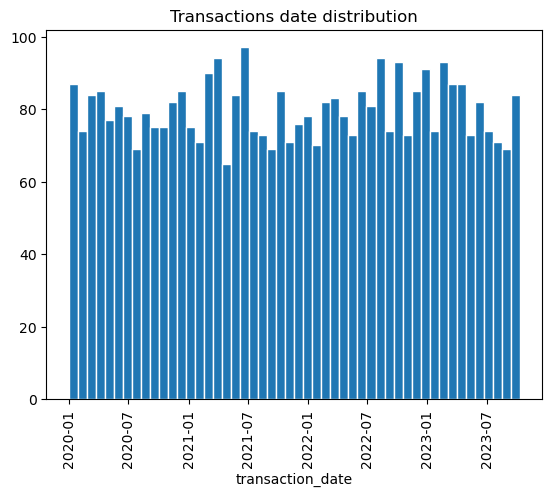

In [26]:
# Histogram for transaction date distribution.
plt.hist(card_data_transaction_date, bins=50, edgecolor='white')
plt.title("Transactions date distribution")
plt.xlabel("transaction_date")
plt.xticks(rotation=90, ha='center')
plt.show()

In [27]:
# Created new columns regarding year.
transactions_per_year = card_data.groupby(card_data_transaction_year).size()
transactions_per_year = transactions_per_year.reset_index()
transactions_per_year.columns = ['Year', 'Transaction per year']
transactions_per_year


,Year,Transaction per year
0,2020,1047
1,2021,1050
2,2022,1072
3,2023,820


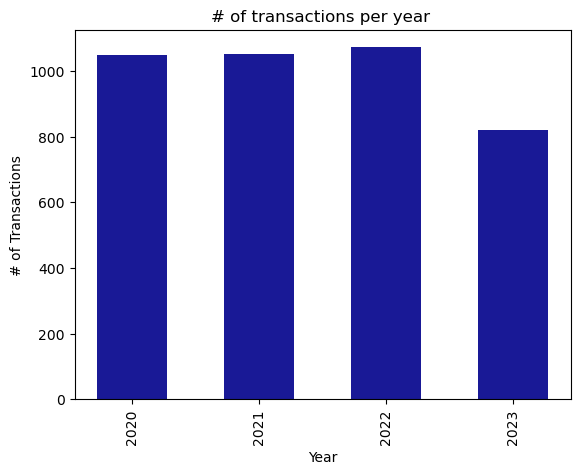

<Figure size 640x480 with 0 Axes>

In [28]:
# Created bar graph to show transactions per year.
x_axis = transactions_per_year['Year']
y_axis = transactions_per_year['Transaction per year']

tick_locations = []

for x in x_axis:
    tick_locations.append(x)

plt.bar(x_axis, y_axis, color="darkblue", alpha=0.9, align="center", width=0.55)
plt.xticks(tick_locations, rotation=90, ha='center')
plt.title("# of transactions per year ")
plt.xlabel("Year")
plt.ylabel("# of Transactions")
plt.show()
plt.savefig('output/Fig1.png')

#### We can easily see that the transactions through credit card has significantly decreased on the year '2023', we believe that the after math of covid-19 has carried over until the 2020 to 2022

In [29]:
# Created new columns regarding month.
transactions_per_month = card_data.groupby(card_data_transaction_month).size()
transactions_per_month = transactions_per_month.reset_index()
transactions_per_month.columns = ['Month', 'Transactions per month']
transactions_per_month

,Month,Transactions per month
0,1,354
1,2,340
2,3,385
3,4,345
4,5,341
5,6,368
6,7,339
7,8,345
8,9,354
9,10,279


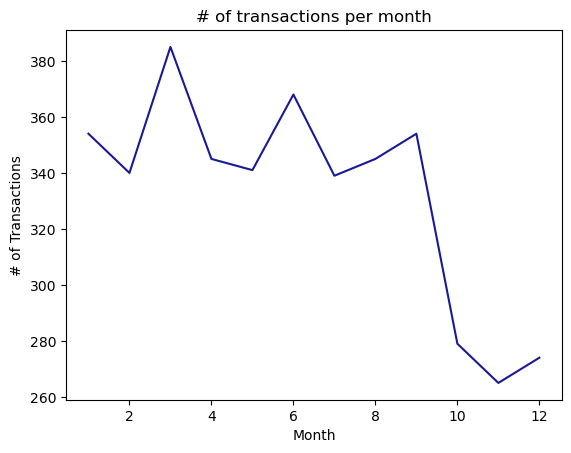

In [30]:
# Created bar graph to show transactions per month. (1 = January)
x_axis = transactions_per_month['Month']
y_axis = transactions_per_month['Transactions per month']

plt.plot(x_axis, y_axis, color="darkblue", alpha=0.9)
plt.title("# of transactions per month")
plt.xlabel("Month")
plt.ylabel("# of Transactions")
plt.show()

#### Based on the yearly transaction graph, we dig little deeper and look at the trends on monthly transactions. Surprisingly, the amount of transactions from users significantly dips on the September and going into the end of the year.

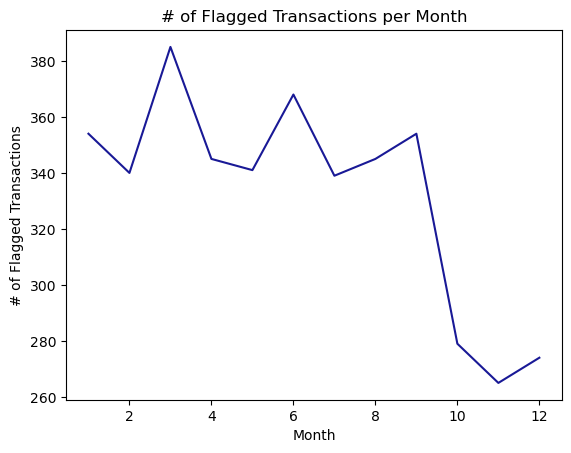

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot the number of fraudulent transactions per month
x_axis = flagged_transactions_per_month.index
y_axis = flagged_transactions_per_month.values

plt.plot(x_axis, y_axis, color="darkblue", alpha=0.9)
plt.title("# of Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Flagged Transactions")
plt.show()
plt.savefig('output/Fig2.png')

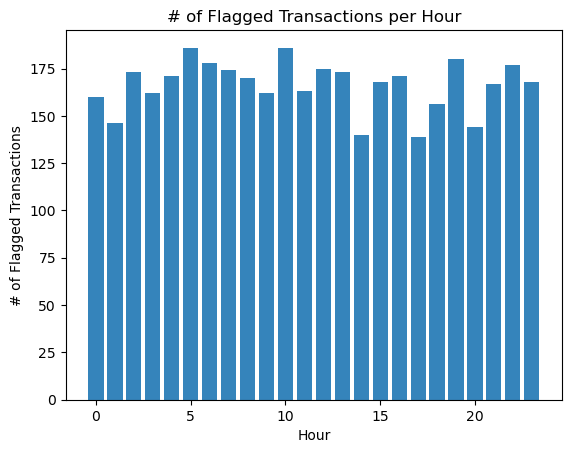

<Figure size 640x480 with 0 Axes>

In [32]:
# Created bar graph
x_axis = flagged_transactions_per_hour.index
y_axis = flagged_transactions_per_hour.values

plt.bar(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Hour")
plt.xlabel("Hour")
plt.ylabel("# of Flagged Transactions")
plt.show()
plt.savefig('output/Fig3.png')


#### Based on this bar graph we can see that 5:00am, 10:00am, 7:00pm has the highest flagged transactions; therefore, as a credit card company they need to staff the customer support agents to appropriate time slot. 

The r_value is: -0.7438931510673467


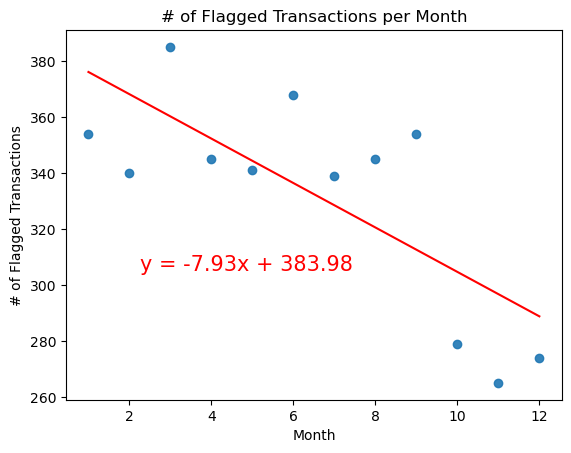

<Figure size 640x480 with 0 Axes>

In [33]:
# Aggregate the data to get the total count of fraudulent transactions per month
fraud_transactions_per_month_id_0 = flagged_transactions_per_month_id.groupby(level=0).count()

x_axis = fraud_transactions_per_month_id_0.index
y_axis = fraud_transactions_per_month_id_0.values

# Perform linear regression
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, y_axis)

# Create equation of line to calculate predicted fraudulent transaction
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

# Generate a scatter plot of fraudulent transactions over months
plt.scatter(x_axis, y_axis, alpha=0.9)
plt.title("# of Flagged Transactions per Month")
plt.xlabel("Month")
plt.ylabel("# of Flagged Transactions")

# Plot the regression line
plt.plot(x_axis, intercept + slope*x_axis, 'r', label='fitted line')

# Annotate the plot with the linear equation
plt.annotate(line_eq, xy=(0.15, 0.35), xycoords='axes fraction', fontsize=15, color="red")

print(f"The r_value is: {r_value}")

plt.show()

plt.savefig('output/Fig4.png')

#### The r-value of -0.74 suggest that there is a strong negative correlation between the month (x-axis) and the number of flagged transactions (y-axis). This means that as time progresses, the number of flagged transactions tends to decrease. For each month that passes, the model predicts approximately 7.93 fewer flagged transactions. However, this is a simple model and doesn’t prove causation, so other factors could also be influencing the decrease in flagged transactions.

In [34]:
# Exchange rates to USD (example rates, replace with actual rates)
exchange_rates = {
    "USD": 1.0,    # USD to USD
    "EUR": 1.2,    # 1 EUR = 1.2 USD
    "INR": 0.013   # 1 INR = 0.013 USD
}

# Function to convert amounts to USD
def convert_to_usd(amount, currency):
    return amount * round(exchange_rates[currency],2)

# Apply conversion to the dataframe
flagged_data["Amount in USD"] = flagged_data.apply(lambda row: convert_to_usd(row["Transaction Amount"], row["Transaction Currency"]), axis=1)

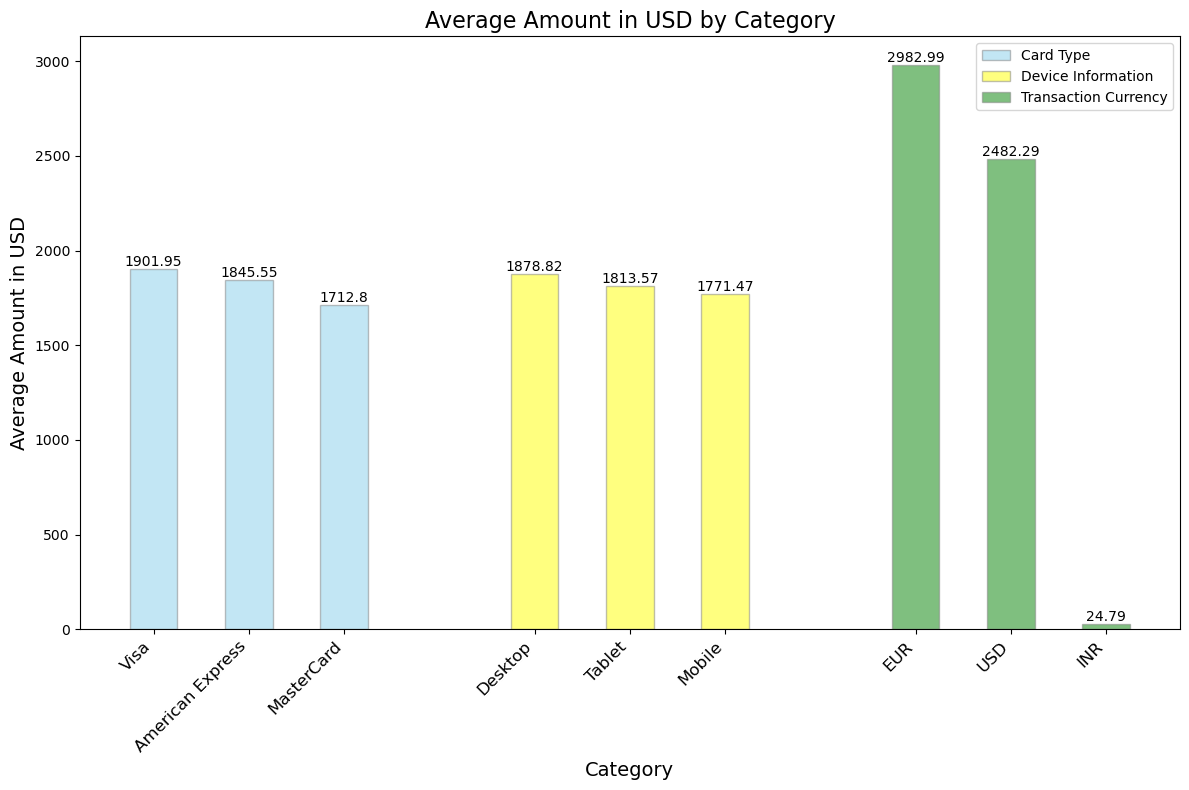

<Figure size 640x480 with 0 Axes>

In [35]:
# Calculate the average transaction amount for each category and sort as per the provided parameters
card_type_avg = flagged_data.groupby("Card Type")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
device_type_avg = flagged_data.groupby("Device Information")["Amount in USD"].mean().sort_values(ascending=False).reset_index()
currency_type_avg = flagged_data.groupby("Transaction Currency")["Amount in USD"].mean().sort_values(ascending=False).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Bar width
bar_width = 0.5

# Set bar positions for each category with a small gap between categories
gap = 1
r1 = np.arange(len(card_type_avg))
r2 = np.arange(len(device_type_avg)) + len(card_type_avg) + gap
r3 = np.arange(len(currency_type_avg)) + len(card_type_avg) + len(device_type_avg) + 2 * gap

# Plot bars
bars1 = plt.bar(r1, card_type_avg["Amount in USD"], color="skyblue", width=bar_width, edgecolor="grey", label="Card Type", alpha=0.5)
bars2 = plt.bar(r2, device_type_avg["Amount in USD"], color="yellow", width=bar_width, edgecolor="grey", label="Device Information", alpha=0.5)
bars3 = plt.bar(r3, currency_type_avg["Amount in USD"], color="green", width=bar_width, edgecolor="grey", label="Transaction Currency", alpha=0.5)

# Add labels for x-axis
all_positions = list(r1) + list(r2) + list(r3)
all_labels = list(card_type_avg["Card Type"]) + list(device_type_avg["Device Information"]) + list(currency_type_avg["Transaction Currency"])

plt.xlabel("Category", fontsize=14)
plt.xticks(all_positions, all_labels, rotation=45, ha='right', fontsize=12)

# Adding titles and labels
plt.title("Average Amount in USD by Category", fontsize=16)
plt.ylabel("Average Amount in USD", fontsize=14)

# Adding a legend
plt.legend()

# Adding text labels inside the bars
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()

# Show the plot
plt.show()

plt.savefig('output/Fig5.png')

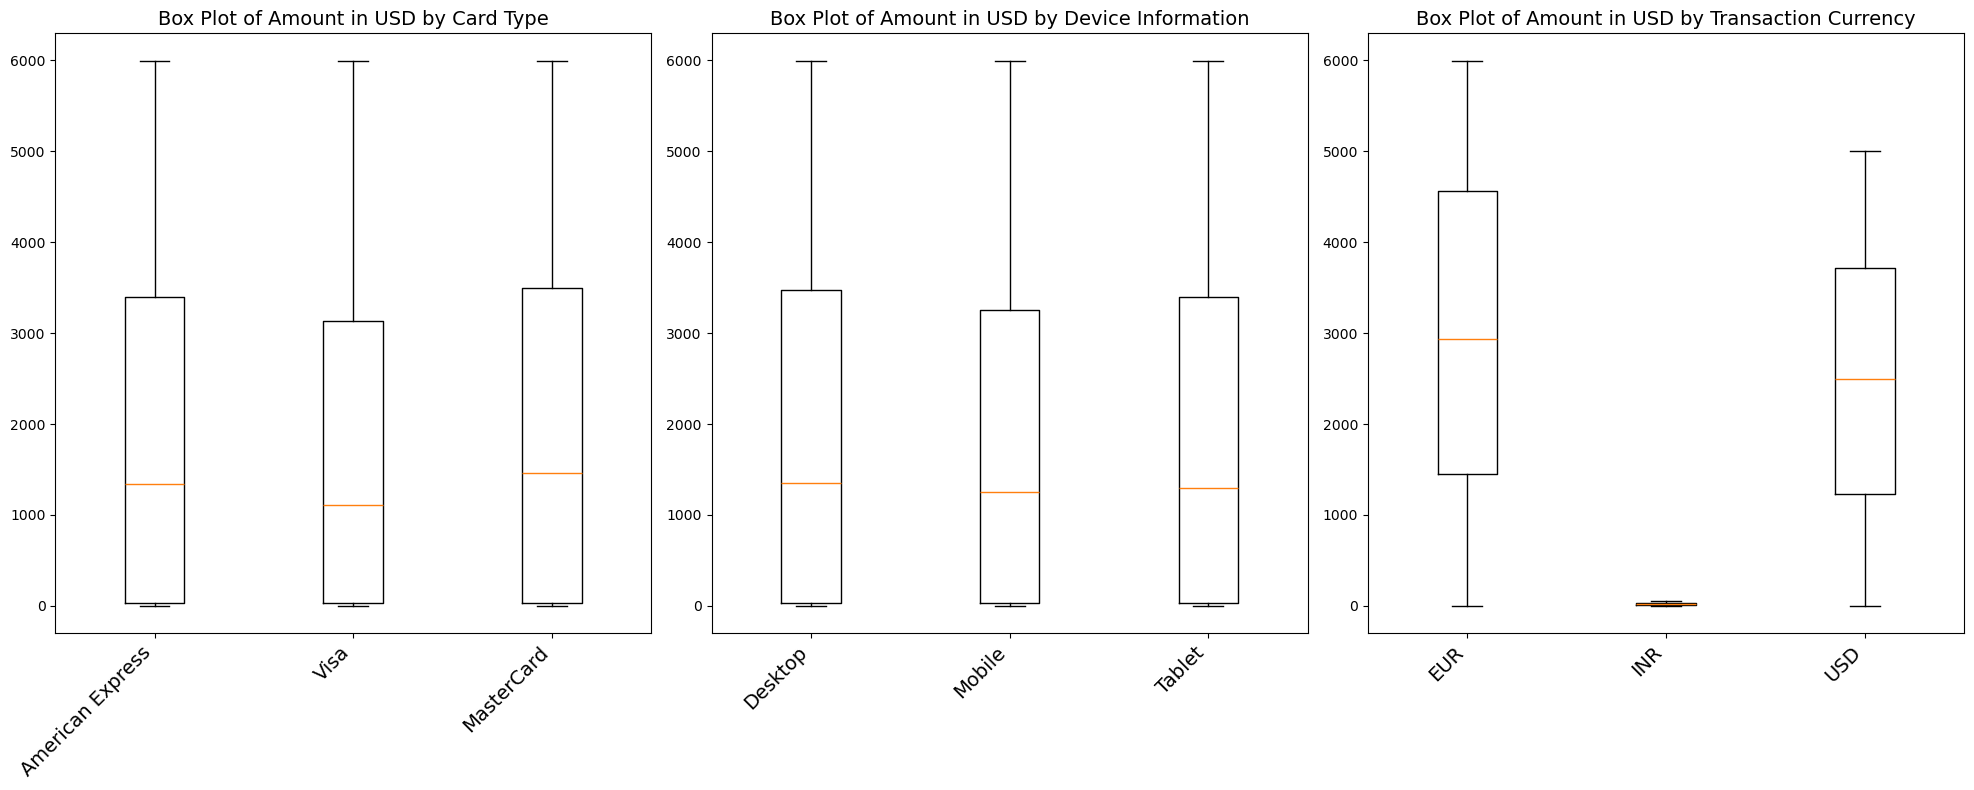

In [36]:
#Creating subplots for 3 categories vs transxn amount
# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Box Plot for Card Type
axes[0].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Card Type')])
axes[0].set_title('Box Plot of Amount in USD by Card Type',fontsize=14)
axes[0].set_xticklabels(flagged_data['Card Type'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Device Information
axes[1].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Device Information')])
axes[1].set_title('Box Plot of Amount in USD by Device Information',fontsize=14)
axes[1].set_xticklabels(flagged_data['Device Information'].unique(), rotation=45, ha='right',fontsize=14)

# Box Plot for Transaction Currency
axes[2].boxplot([group["Amount in USD"].values for name, group in flagged_data.groupby('Transaction Currency')])
axes[2].set_title('Box Plot of Amount in USD by Transaction Currency',fontsize=14)
axes[2].set_xticklabels(flagged_data['Transaction Currency'].unique(), rotation=45, ha='right',fontsize=14)

plt.tight_layout()
plt.show()

In [37]:
# Perform ANOVA using statsmodels
# Combine all categorical columns into a long format for ANOVA
df_long = pd.melt(flagged_data, id_vars=['Amount in USD'], value_vars=['Card Type', 'Device Information', 'Transaction Currency'],
                  var_name='Category', value_name='Type')

# Perform ANOVA using statsmodels
model = ols('Q("Amount in USD") ~ C(Type)', data=df_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform ANOVA using scipy.stats (for each category separately)
card_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Card Type')])
device_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Device Information')])
currency_type_anova = f_oneway(*[group["Amount in USD"].values for name, group in flagged_data.groupby('Transaction Currency')])

print("ANOVA results for Card Type:", card_type_anova)
print("ANOVA results for Device Information:", device_type_anova)
print("ANOVA results for Transaction Currency:", currency_type_anova)

                sum_sq       df           F  PR(>F)
C(Type)   6.735368e+09      8.0  296.235843     0.0
Residual  3.398539e+10  11958.0         NaN     NaN
ANOVA results for Card Type: F_onewayResult(statistic=3.6837999050157664, pvalue=0.02521289817212182)
ANOVA results for Device Information: F_onewayResult(statistic=1.1523363263123119, pvalue=0.31600307989524856)
ANOVA results for Transaction Currency: F_onewayResult(statistic=1944.0899078049017, pvalue=0.0)


ANOVA Results Interpretation:
Card Type:


p-value: 0.025
Interpretation:

The p-value (0.025) is less than the typical significance level of 0.05, indicating that there are statistically significant differences in the average transaction amounts across different Card Types.

Device Information:
p-value: 0.316
Interpretation:

The p-value (0.316) is greater than 0.05, indicating that there is no statistically significant difference in the average transaction amounts across different Device Information categories.


Transaction Currency:
p-value: 0.0
Interpretation:

The p-value (0.0) is much less than 0.05, indicating a highly significant difference in the average transaction amounts across different Transaction Currencies.

Conclusion:
Card Type: There are significant differences in average transaction         amounts between different card types.

Device Information: There are no significant differences in average transaction amounts between different device types.

Transaction Currency: There are highly significant differences in average transaction amounts between different currencies.

In [38]:
source_counts = flagged_data["Transaction Source"].value_counts()
source_counts

Transaction Source
In-Person    2024
Online       1965
Name: count, dtype: int64

Interpretation:

The data shows a nearly even split between In-Person and Online transactions.
In-Person transactions are slightly higher by a margin of 59 transactions.

In [40]:
#Accessing Merchant Category Codes and thier occurences
mcc_counts =flagged_data["Merchant Category Code (MCC)"].value_counts()
mcc_counts=mcc_counts.reset_index()
mcc_counts.columns=["Mcc","Counts"]
filtered_mcc=mcc_counts.loc[mcc_counts["Counts"]==4]

#Providing description to the MCC
bins = [0, 1500, 3000, 3300, 3500, 4000, 4800, 5000, 5700, 7300, 8000, 9000, 10000]
descriptions = [
    "Agricultural services",
    "Contracted services",
    "Airlines",
    "Car rentals",
    "Lodging",
    "Transportation services",
    "Utility services",
    "Retail outlet services",
    "Miscellaneous stores",
    "Business services",
    "Professional services and membership organizations",
    "Government services"
]
#Adding Description column to MCC
final_mcc = filtered_mcc.copy()
final_mcc.loc[:, "Description"] = pd.cut(filtered_mcc["Mcc"], bins, labels=descriptions, include_lowest=True)
final_mcc

#Filtering MCC codes with max occurence of 4
grouped_df = final_mcc.groupby('Description',observed=True)["Counts"].sum().reset_index()
filtered_df = grouped_df[grouped_df['Counts'] >= 4]

#Sorting MCC by their number of occurences
filtered_df = filtered_df.reset_index(drop=True).sort_values(by='Counts', ascending=False)
print(filtered_df.to_string(index=False))

          Description  Counts
  Government services      20
 Miscellaneous stores      12
Agricultural services       8
  Contracted services       4
          Car rentals       4
              Lodging       4


## This portion of the analysis contains observing Capital and the average transaction amounts where fraudulent flag equals 1.

In [41]:
# Count unique number of capital in the database
flagged_data['Capital'].nunique()

117

In [42]:
# Remove duplicate rows based on Country
card_data_dedup = flagged_data.drop_duplicates(subset=['Capital'])

# Check that the filtered data frame is the same size as the number of unique countries
card_data_dedup.count()

Transaction ID                             117
IP                                         117
City                                       115
Lat                                        117
Lng                                        117
Continent                                  117
Capital                                    117
Country                                    117
Transaction Date and Time                  117
Transaction Amount                         117
Cardholder Name                            117
Card Number (Hashed or Encrypted)          117
Merchant Name                              117
Merchant Category Code (MCC)               117
Transaction Location (City or ZIP Code)    117
Transaction Currency                       117
Card Type                                  117
Card Expiration Date                       117
CVV Code (Hashed or Encrypted)             117
Transaction Response Code                  117
Fraud Flag or Label                        117
Previous Tran

In [43]:
# Sort the Dataframe by Country
card_data_dedup = card_data_dedup.sort_values('Capital')

# Set country as index
#card_data_dedup.set_index('Country', inplace=True)

# Display Sample Data
card_data_dedup.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount,...,Fraud Flag or Label,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes,Month,Hour,Amount in USD
223,16a26a3f-e596-495c-a0d6-2dbc1345eec9,195.229.230.175,Dubai,25.01267,55.09019,Asia,Abu Dhabi,United Arab Emirates,2021-04-24 03:27:18,2861.93,...,1,3 or more,In-Person,195.229.230.175,Tablet,goelnirvi,Sequi ducimus rerum corrupti architecto praese...,4,3,28.6193
455,07f79037-ef9f-4905-9b20-400b99e1f59c,102.131.133.64,Jos,9.94782,8.88881,Africa,Abuja,Nigeria,2020-03-31 13:55:10,777.78,...,1,2,In-Person,102.131.133.64,Desktop,amanikapoor,Recusandae non accusamus doloremque velit. Sit...,3,13,933.3360
266,40b74a91-b545-4b91-9ec1-c8baaf0f493b,196.175.143.7,Accra,5.57005,-0.19738,Africa,Accra,Ghana,2020-08-24 02:26:02,3404.56,...,1,3 or more,Online,196.175.143.7,Tablet,parideo,Laborum distinctio soluta. Modi reiciendis sae...,8,2,4085.4720
32,1132d2b7-2c66-4460-ac58-4ec5ff06770a,196.191.204.0,Wereda 02,9.02740,38.75152,Africa,Addis Ababa,Ethiopia,2020-02-18 21:35:18,2401.90,...,1,1,Online,196.191.204.0,Desktop,NaN,Sapiente molestiae quasi expedita animi. Illo ...,2,21,24.0190
426,e2086b87-001c-4769-98e1-a0abdab34dbf,154.254.2.209,Algiers,36.72135,3.14541,Africa,Algiers,Algeria,2022-10-02 03:19:10,40.03,...,1,1,Online,154.254.2.209,Mobile,NaN,Vitae tempore veritatis laudantium voluptas vo...,10,3,48.0360


In [44]:
# Find out what are the top countries number of fruads occured 
flagged_data['Capital'].value_counts()

Capital
Washington, D.C.    1582
Beijing              384
Tokyo                251
Berlin               137
London               136
                    ... 
Dodoma                 1
Dushanbe               1
Nuuk                   1
Doha                   1
Cayenne                1
Name: count, Length: 117, dtype: int64

In [45]:
# Get mean value of Transaction Amount Per Country
avg_txn_amt_by_cntry = flagged_data.groupby('Capital', as_index=False)['Transaction Amount'].mean()
avg_txn_amt_by_cntry = avg_txn_amt_by_cntry.sort_values('Capital')
avg_txn_amt_by_cntry['Transaction Amount'] = round(avg_txn_amt_by_cntry['Transaction Amount'],2)

# Display sample data and check that it has the same number of rows as the dedup table
avg_txn_amt_by_cntry

,Capital,Transaction Amount
0,Abu Dhabi,3453.99
1,Abuja,1016.45
2,Accra,1157.85
3,Addis Ababa,2401.90
4,Algiers,2225.78
...,...,...
112,Willemstad,1845.59
113,Windhoek,3163.46
114,Yamoussoukro,4472.12
115,Yerevan,584.52


In [46]:
# Join the dedup dataframe and the fraud transaction mean dataframe
card_data_dedup_txn = pd.merge(card_data_dedup, avg_txn_amt_by_cntry, how="left", on=['Capital'])

# Rename the new merged column to Avg. Transaction Amount
card_data_dedup_txn.rename(columns={'Transaction Amount_y': 'Avg. Transaction Amount'}, inplace=True)

# Reset the index
card_data_dedup_txn.reset_index()

# Display sample data
card_data_dedup_txn.head()

,Transaction ID,IP,City,Lat,Lng,Continent,Capital,Country,Transaction Date and Time,Transaction Amount_x,...,Previous Transactions,Transaction Source,IP Address,Device Information,User Account Information,Transaction Notes,Month,Hour,Amount in USD,Avg. Transaction Amount
0,16a26a3f-e596-495c-a0d6-2dbc1345eec9,195.229.230.175,Dubai,25.01267,55.09019,Asia,Abu Dhabi,United Arab Emirates,2021-04-24 03:27:18,2861.93,...,3 or more,In-Person,195.229.230.175,Tablet,goelnirvi,Sequi ducimus rerum corrupti architecto praese...,4,3,28.6193,3453.99
1,07f79037-ef9f-4905-9b20-400b99e1f59c,102.131.133.64,Jos,9.94782,8.88881,Africa,Abuja,Nigeria,2020-03-31 13:55:10,777.78,...,2,In-Person,102.131.133.64,Desktop,amanikapoor,Recusandae non accusamus doloremque velit. Sit...,3,13,933.3360,1016.45
2,40b74a91-b545-4b91-9ec1-c8baaf0f493b,196.175.143.7,Accra,5.57005,-0.19738,Africa,Accra,Ghana,2020-08-24 02:26:02,3404.56,...,3 or more,Online,196.175.143.7,Tablet,parideo,Laborum distinctio soluta. Modi reiciendis sae...,8,2,4085.4720,1157.85
3,1132d2b7-2c66-4460-ac58-4ec5ff06770a,196.191.204.0,Wereda 02,9.02740,38.75152,Africa,Addis Ababa,Ethiopia,2020-02-18 21:35:18,2401.90,...,1,Online,196.191.204.0,Desktop,NaN,Sapiente molestiae quasi expedita animi. Illo ...,2,21,24.0190,2401.90
4,e2086b87-001c-4769-98e1-a0abdab34dbf,154.254.2.209,Algiers,36.72135,3.14541,Africa,Algiers,Algeria,2022-10-02 03:19:10,40.03,...,1,Online,154.254.2.209,Mobile,NaN,Vitae tempore veritatis laudantium voluptas vo...,10,3,48.0360,2225.78


In [47]:
# Filter columns for Map - Capital, Lat, Lng, Avg transact Amount, Continent, 
map_df = card_data_dedup_txn[['Capital', 'Lat', 'Lng', 'Avg. Transaction Amount', 'Continent']]

# Display sample data
map_df.head()

,Capital,Lat,Lng,Avg. Transaction Amount,Continent
0,Abu Dhabi,25.01267,55.09019,3453.99,Asia
1,Abuja,9.94782,8.88881,1016.45,Africa
2,Accra,5.57005,-0.19738,1157.85,Africa
3,Addis Ababa,9.02740,38.75152,2401.90,Africa
4,Algiers,36.72135,3.14541,2225.78,Africa


In [50]:
# Convert the coordinates to Web Mercator
map_df['x'], map_df['y'] = lon_lat_to_easting_northing(map_df.Lng, map_df.Lat)

# Display sample data
map_df.head()

C:\Users\Ernie\AppData\Local\Temp\ipykernel_26036\2879346399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['x'], map_df['y'] = lon_lat_to_easting_northing(map_df.Lng, map_df.Lat)
C:\Users\Ernie\AppData\Local\Temp\ipykernel_26036\2879346399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['x'], map_df['y'] = lon_lat_to_easting_northing(map_df.Lng, map_df.Lat)


,Capital,Lat,Lng,Avg. Transaction Amount,Continent,x,y
0,Abu Dhabi,25.01267,55.09019,3453.99,Asia,6.132612e+06,2.877301e+06
1,Abuja,9.94782,8.88881,1016.45,Africa,9.894978e+05,1.112992e+06
2,Accra,5.57005,-0.19738,1157.85,Africa,-2.197224e+04,6.210341e+05
3,Addis Ababa,9.02740,38.75152,2401.90,Africa,4.313799e+06,1.009109e+06
4,Algiers,36.72135,3.14541,2225.78,Africa,3.501454e+05,4.400337e+06


## Analysis
The following image is derived by calling 
 ip Geo location API (web source:  https://app.ipgeolocation.io/) using the IP Address provided in the data source.
 The API uses the IP address passed as an argument and returns information such as the Latitude, Longtitude, Country Name, 
 Country's Capital and Continent which we will use for analysis.


Based on the geo location map below, we observe that most of the credit card transactions where Fraud Flag = 1 take place in Europe.

In [51]:
# Checking Minimum and Maximum Avg. Transaction Amounts
print("Max Ave. Transaction Amount: " + str(max(map_df['Avg. Transaction Amount'])))
print("Min Ave. Transaction Amount: " + str(min(map_df['Avg. Transaction Amount'])))

Max Ave. Transaction Amount: 4993.49
Min Ave. Transaction Amount: 43.08


In [52]:
# Define ranges for marker size to plot
bins = [0, 1000, 2000, 3000, 4000, 5000]

# The labels list will be used for plotting - Marker size
labels = ['50', '100', '150', '200', '250']
map_df['Marker'] = pd.cut(map_df['Avg. Transaction Amount'], bins=bins, labels=labels)

# Convert the Dataframe into numeric for Marker size
map_df['Marker'] = pd.to_numeric(map_df['Marker'], errors='coerce')

C:\Users\Ernie\AppData\Local\Temp\ipykernel_26036\40767530.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['Marker'] = pd.cut(map_df['Avg. Transaction Amount'], bins=bins, labels=labels)
C:\Users\Ernie\AppData\Local\Temp\ipykernel_26036\40767530.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  map_df['Marker'] = pd.to_numeric(map_df['Marker'], errors='coerce')


In [54]:
# Plot map - Fraudulent Transactions by Capital
map_plot_1 = map_df.hvplot.points(
    'x', 
    'y', 
    tiles = True,
    frame_width = 800,
    frame_height = 600, 
    alpha=0.7,
    size = "Marker",
    color = 'Capital',
    hover_cols = ['Capital', 'Avg. Transaction Amount', 'Continent'],
    title='Flagged Transactions by Capital'
    )

map_plot_1
#hvplot.save(map_plot_1, 'output/Fig6.png')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (Capital,Marker,Avg. Transaction Amount,Continent)

## Analysis

The average fraudulent transaction amount was calculated and charted against latitue to see if there are any correlations between the two. There does not appear to be any significat correlation between these 2 measures.

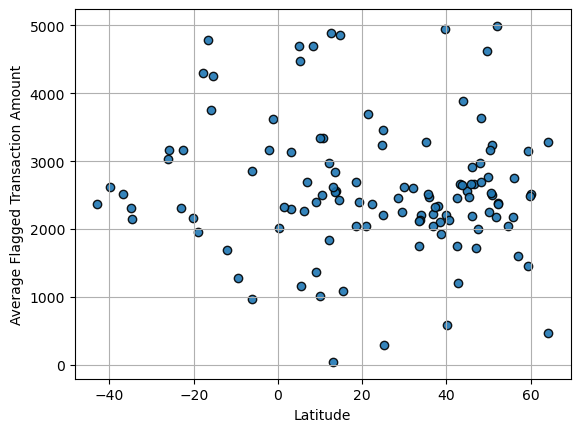

<Figure size 640x480 with 0 Axes>

In [55]:
# Build the scatter plots for latitude vs. average fradulent transaction amount
x_values = card_data_dedup_txn['Lat']
y_values = card_data_dedup_txn['Avg. Transaction Amount']

# Plot the scatter plot with datapoints edge folor = black and opicity=90%
plt.scatter(x_values,y_values,alpha=0.9, edgecolors='black')
plt.xlabel('Latitude')
plt.ylabel('Average Flagged Transaction Amount')
plt.grid('on')

# Show plot
plt.show()
plt.savefig('output/Fig7.png')

In [56]:
# Check the count for each continent
map_df['Continent'].value_counts()

Continent
Europe           37
Asia             31
Africa           22
North America    13
South America    10
Oceania           4
Name: count, dtype: int64

## Analysis 

The Pie chart below helps us visualize the distribution of flagged activities between continents. As previously note, Europe had the most activities followed by Asia and Africa.

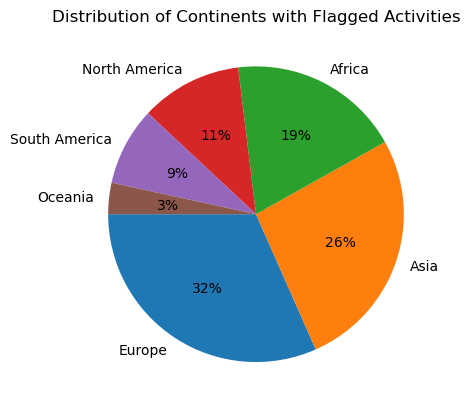

<Figure size 640x480 with 0 Axes>

In [57]:
# Generate a pie plot showing the distribution of Continents with fraudulent activities

# Get the labels and values 
seriesLabels_pie = ['Europe','Asia','Africa','North America','South America','Oceania']
seriesValues_pie = map_df['Continent'].value_counts()

# Draw bar chart
plt.pie(seriesValues_pie, labels=seriesLabels_pie, autopct='%1.0f%%',startangle=180)

# Set the labels
plt.title("Distribution of Continents with Flagged Activities")

# Show the pie chart
plt.show()
plt.savefig('output/Fig8.png')